# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [20]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

# Exploratory data analysis (EDA) 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

#### Storing the words dictionary in a dataframe and replacing '\n' with blank space

In [22]:
words_dictinary = open("words_250000_train.txt", "r")
df = []
for x in words_dictinary:
  df.append(x)

In [23]:
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")

In [24]:
vowels_list = ['a', 'e', 'i', 'o', 'u']

#### Function for calculating ratio of vowels to length of word

In [25]:
def vowel_count(word):
    count = 0
    
    for i in word:
        if i in vowels_list:
            count = count+1.0
    return count/len(word)

#### Applying the vowel_count function over the dataframe

In [26]:
vowel_count_for_given_length=[]
for words in df:
    vowel_count_for_given_length.append(vowel_count(words))
vowel_count_for_given_length = pd.Series(vowel_count_for_given_length)
vowel_count_for_given_length.describe()

count    227300.000000
mean          0.386889
std           0.095527
min           0.000000
25%           0.333333
50%           0.384615
75%           0.444444
max           1.000000
dtype: float64

# Plotting the Dataset

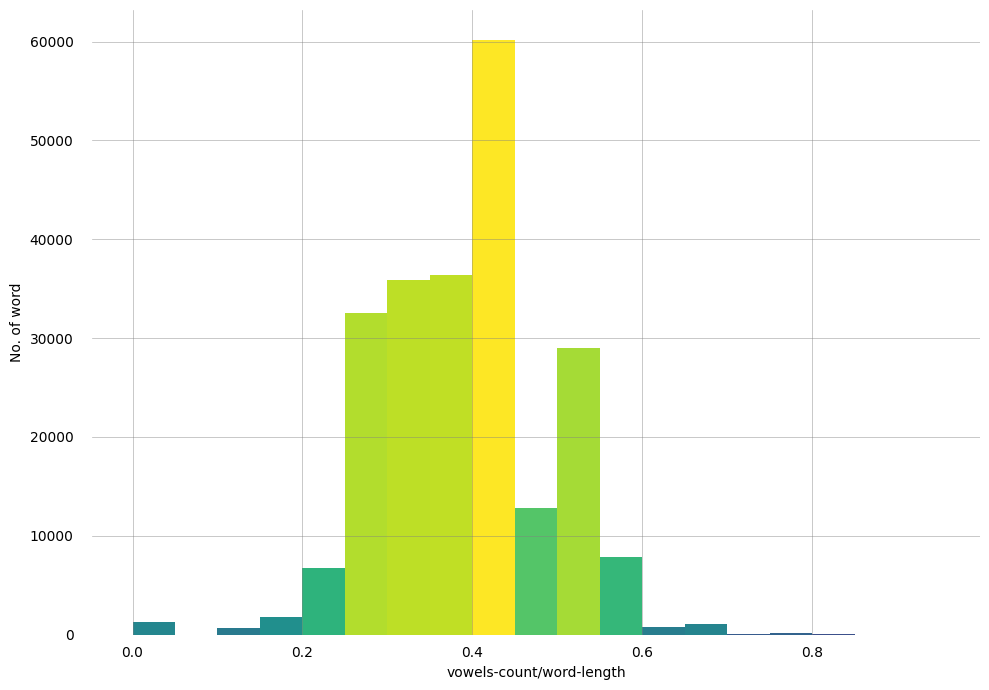

In [27]:
# Define the bins for the histogram
bins = np.arange(0.0, 1.0, 0.05)

# Creating histogram
fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')

# Add padding between axes and labels
axs.xaxis.set_tick_params(pad=5)
axs.yaxis.set_tick_params(pad=10)

# Creating histogram
N, bins, patches = axs.hist(x=vowel_count_for_given_length, bins=bins)

# Setting color
fracs = ((N**(1 / 5)) / N.max())
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# Add x, y gridlines
axs.grid( color='grey', linestyle='-', linewidth=0.5, alpha=0.6)

# Adding extra features
plt.xlabel("vowels-count/word-length")
plt.ylabel("No. of word")
# plt.title('Histogram')

# Show plot
plt.show()

From the above plot we can statiscally say that if the number of vowels in it are greater than 0.6 times of its length than guessing a vowel will not be a good choice.

### NGrams function

In [28]:
def getNGrams(guessed_word,n):
    ngrams = {}
    for word in guessed_word:
        if len(word) <n:
            continue
        for i in range(len(word)-n+1):
            ngram = word[i:i+n]
            if ngram not in ngrams:
                ngrams[ngram] = 1
            else:
                ngrams[ngram]+=1
    return ngrams


## Testing NGrams function

In [29]:
word=["de_f"]
print(getNGrams(word,1))

{'d': 1, 'e': 1, '_': 1, 'f': 1}


# LSTM model

In [30]:

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributed as dist
import collections
# Check if CUDA is available
CUDA = torch.cuda.is_available()

# Function to load the trained model from a given path
def load_model(model_path):
    model = RNN_model(target_dim=26, hidden_units=16)
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

# Function to display the game status - original word, guesses, and obscured words seen
def show_game(original_word, guesses, obscured_words_seen):
    print('Hidden word was "{}"'.format(original_word))

    for i in range(len(guesses)):
        word_seen = ''.join([chr(i + 97) if i != 26 else ' ' for i in obscured_words_seen[i].argmax(axis=1)])
        print('Guessed {} after seeing "{}"'.format(guesses[i], word_seen))
        
# Function to convert a Python list to a PyTorch tensor
def list_to_tensor_convertor(arr):
    arr = np.array(arr)
    return torch.from_numpy(arr)

# Class to handle game logic and encoding for training
class Word2Batch:
    def __init__(self, model, word, lives=6):
        self.origin_word = word
        self.guessed_letter = set()   #Store guessed letters as indices
        self.word_idx = [ord(i)-97 for i in word] # Convert characters to corresponding indices (0-25)
        self.remain_letters = set(self.word_idx)  # Set of remaining letters to guess
        self.model = model
        self.lives_left = lives
        self.guessed_letter_each = []

        # Lists to store the dataset for variable-to-output (input-to-label) pairs
        self.obscured_word_seen = []  # n * 27, where n is the number of guesses
        self.prev_guessed = []  # n*26, where n is the number of guesses and each element is the normalized word idx
        self.correct_response = []  # this is the label, meaning self.prev_guess should be one of self.correct_response
 
 # Function to convert guessed word into a one-hot encoded tensor
    def converting_guessed_word(self):
        word = [i if i in self.guessed_letter else 26 for i in self.word_idx]
        obscured_word = np.zeros((len(word), 27), dtype=np.float32)
        for i, j in enumerate(word):
            obscured_word[i, j] = 1
        return obscured_word

# Function to encode the previous guesses into a one-hot encoded tensor
    def encode_prev_guess(self):
        guess = np.zeros(26, dtype=np.float32)
        for i in self.guessed_letter:
            guess[i] = 1.0
        return guess

    # Function to encode the correct response (remaining letters) into a one-hot encoded tensor
    def encode_correct_response(self):
        response = np.zeros(26, dtype=np.float32)
        for i in self.remain_letters:
            response[i] = 1.0
        response /= response.sum()
        return response
    
    # Function to play the game and mimic the gameplay for training data generation
    def game_mimic(self):
        obscured_words_seen = []
        prev_guess_seen = []
        correct_response_seen = []

        while self.lives_left > 0 and len(self.remain_letters) > 0:
            # Store obscured word and previous guesses as input (X) for the model
            obscured_word = self.converting_guessed_word()
            prev_guess = self.encode_prev_guess()

            obscured_words_seen.append(obscured_word)
            prev_guess_seen.append(prev_guess)
            obscured_word = torch.from_numpy(obscured_word)
            prev_guess = torch.from_numpy(prev_guess)
            if CUDA:
                obscured_word = obscured_word.cuda()
                prev_guess = prev_guess.cuda()

            self.model.eval()
            guess = self.model(obscured_word, prev_guess)  # Output of guess should be a 1 by 26 vector
            guess = torch.argmax(guess, dim=2).item()
            self.guessed_letter.add(guess)
            self.guessed_letter_each.append(chr(guess + 97))

            # Store correct response (label) for the model
            correct_response = self.encode_correct_response()
            correct_response_seen.append(correct_response)

            # Update remaining letters and lives left based on the guess
            if guess in self.remain_letters:  # Only remove guess when the guess is correct
                self.remain_letters.remove(guess)

            if correct_response_seen[-1][guess] < 0.0000001:  # Which means we made a wrong guess
                self.lives_left -= 1

        # Convert lists to PyTorch tensors
        obscured_words_seen = list_to_tensor_convertor(obscured_words_seen)
        prev_guess_seen = list_to_tensor_convertor(prev_guess_seen)
        correct_response_seen = list_to_tensor_convertor(correct_response_seen)

        return obscured_words_seen, prev_guess_seen, correct_response_seen


# Class defining the Stateful LSTM module
class StatefulLSTM(nn.Module):
    def __init__(self, in_size, out_size):
        super(StatefulLSTM, self).__init__()

        self.lstm = nn.LSTMCell(in_size, out_size)
        self.out_size = out_size

        self.h = None
        self.c = None


# Class defining the Stateful LSTM module
    def reset_state(self):
        self.h = None
        self.c = None

    def forward(self, x):
        batch_size = x.data.size()[0]
        if self.h is None:
            state_size = [batch_size, self.out_size]
            self.c = Variable(torch.zeros(state_size))
            self.h = Variable(torch.zeros(state_size))
            if CUDA:
                self.c = self.c.cuda()
                self.h = self.h.cuda()

        self.h, self.c = self.lstm(x, (self.h, self.c))

        return self.h

#class for dropping out some layer
class LockedDropout(nn.Module):
    def __init__(self):
        super(LockedDropout,self).__init__()
        self.m = None

    def reset_state(self):
        self.m = None

    def forward(self, x, dropout=0.5, train=True):
        if train==False:
            return x
        if(self.m is None):
            self.m = x.data.new(x.size()).bernoulli_(1 - dropout)
        mask = Variable(self.m, requires_grad=False) / (1 - dropout)

        return mask * x

# Class for implementing Locked Dropout
class RNN_model(nn.Module):
    def __init__(self, hidden_units=16, target_dim=26):
        super(RNN_model, self).__init__()
        self.lstm1 = StatefulLSTM(27, hidden_units)
        self.bn_lstm1 = nn.BatchNorm1d(hidden_units)
        self.dropout1 = LockedDropout()
        self.fc = nn.Linear(hidden_units + 26, target_dim)
        
    # Function to reset the LSTM cell and dropout states
    def reset_state(self):
        self.lstm1.reset_state()
        self.dropout1.reset_state()

    def forward(self, obscure_word, prev_guess, train=True):
        if len(obscure_word.size()) < 3:
            obscure_word = obscure_word.unsqueeze(0)
        if len(prev_guess.size()) < 2:
            prev_guess = prev_guess.unsqueeze(0)

        no_of_timesteps = obscure_word.shape[0]
        batch_size = obscure_word.shape[1]
        self.reset_state()

        outputs = []
        for i in range(no_of_timesteps):
            h = self.lstm1(obscure_word[i, :, :])
            h = self.bn_lstm1(h)
            h = self.dropout1(h, dropout=0.1, train=train)

            pool = nn.MaxPool1d(batch_size)
            h = h.permute(1, 0)  # (batch_size,features,time_steps)
            h = h.unsqueeze(0)
            out = pool(h)
            out = out.squeeze(2)
            curr_prev_guess = prev_guess[i, :]
            curr_prev_guess = curr_prev_guess.unsqueeze(0)
            out = torch.cat((out, curr_prev_guess), 1)
            out = self.fc(out)
            outputs.append(out)
        outputs = torch.stack(outputs)
        return outputs

# Create an instance of the RNN_model
model = RNN_model()
print("------------------------------------------------------------MODEL DETAILS-------------------------------------------------\n")
print(model)

------------------------------------------------------------MODEL DETAILS-------------------------------------------------

RNN_model(
  (lstm1): StatefulLSTM(
    (lstm): LSTMCell(27, 16)
  )
  (bn_lstm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): LockedDropout()
  (fc): Linear(in_features=42, out_features=26, bias=True)
)


#### Code used for training the model

In [31]:
import os
import time
import logging
import torch
import torch.nn as nn

# Check if CUDA is available for GPU acceleration
CUDA = torch.cuda.is_available()

# Function to display the game status - original word, guesses, and obscured words seen
def show_game(original_word, guesses, obscured_words_seen):
    print('Hidden word was "{}"'.format(original_word))
    for i in range(len(guesses)):
        word_seen = ''.join([chr(i + 97) if i != 26 else ' ' for i in obscured_words_seen[i].argmax(axis=1)])
        print('Guessed {} after seeing "{}"'.format(guesses[i], word_seen))

# Function to display the game status - original word, guesses, and obscured words seen
def storing_words(file_location):
    with open(file_location, "r") as text_file:
        all_words = text_file.read().splitlines()
    return all_words

# Function to train the model
def train_model():
    # get data
    root_path = os.getcwd()
    file_name = "words_250000_train.txt"
    file_path = os.path.join(root_path, file_name)
    words = storing_words(file_path)
    num_words = len(words)

    # define model
    model = RNN_model(target_dim=26, hidden_units=16)

    # define hyper parameter
    n_epoch = 6
    lr = 0.001
    record_step = 100  # output result every 100 words
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_func = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.1)

    # start training
    start_time = time.perf_counter()
    tot_sample = 0
    for n in range(n_epoch):
        i = 0

        while tot_sample < (n + 1) * num_words:
            word = words[i]
            if len(word) == 1:
                continue
            i += 1
            # generate data in a batch
            new_batch = Word2Batch(word=word, model=model)
            obscured_word, prev_guess, correct_response = new_batch.game_mimic()
            if CUDA:
                obscured_word = obscured_word.cuda()
            optimizer.zero_grad()
            predict = model(obscured_word, prev_guess)
            loss = loss_func(predict, correct_response)
            loss.backward()
            optimizer.step()
            # show loss
            curr_time = time.perf_counter()
            print("for word {}, the BCE loss is {:4f}, time used:{:4f}".format(word, loss.item(), curr_time - start_time))
            # show guess status
            if i % record_step == 0:
                guesses = [chr(i+97) for i in torch.argmax(prev_guess, 1)]
                show_game(word, guesses, obscured_word)
            tot_sample += 1

#### Loading My Trained Model and some helping functions for guessing the word

In [32]:

import argparse
import collections
import pandas as pd
import numpy as np
import torch

# Function to parse command-line arguments for Hangman game configuration
def arg_parser():
    parser = argparse.ArgumentParser(description="hangman game config")
    parser.add_argument("--train_set", type=str, default="words_250000_train.txt",
                        help="path of the train dictionary")
    parser.add_argument("--lives", type=int, default=6,
                        help="upper limit of fail guesses")
    args = parser.parse_args()
    return args


# Function to load the pre-trained model
def load_model(model_path):
    model = RNN_model(target_dim=26, hidden_units=16)
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [33]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None,model_path='model.pth',n_gram=2):
        # Initialize HangmanAPI object with necessary attributes
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        full_dictionary_location="words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.frequency_by_length = self.init_df(self.full_dictionary)
        self.n_gram = self.init_n_gram(n_gram)
        self.current_dictionary = []
        self.history_condition = []
        self.model = load_model(model_path)
        dictionary_file_location="words_250000_train.txt"
        text_file = open(dictionary_file_location,"r")

        words = text_file.read().splitlines()
        self.ngrams=[getNGrams(words,i) for i in range(1,6)]
        
    @staticmethod
    def determine_hangman_url():
        # Static method to determine the appropriate hangman URL for the game
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
        # self.current_dictionary = []
        
    def buildDict(self):
        # Function to build a dictionary from the word file
        dictionary_file_location="words_250000_train.txt"
        text_file = open(dictionary_file_location,"r")
        words = text_file.read().splitlines()
        text_file.close()
        
        self.ngrams=[getNGrams(words,i) for i in range(1,6)]
        
    def ngramprob(self,word,letter ):
        # Function to calculate the probability of a letter in the given word based on n-grams
        denominator=0
        underscroll_location=word.find("_")

        for l in string.ascii_lowercase:
            
            try:
                denominator+=self.ngrams[len(word)-1][word[:underscroll_location]+l+word[underscroll_location+1:]]
            except:
                pass
        return self.ngrams[len(word)-1][word[:underscroll_location]+letter+word[underscroll_location+1:]]/denominator


            
    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
    
    def find_by_gram(self, all_gram, pre=None, suff=None):
        selected_gram = []
        for key, val in all_gram.items():
            if (pre is not None) and (key[0] == pre):
                selected_gram.append((key[1], val))
            if (suff is not None) and (key[1] == suff):
                selected_gram.append((key[0], val))

        res = {}
        for letter, frequency in selected_gram:
            if letter not in res:
                res[letter] = frequency
            else:
                res[letter] += frequency
        final_res = [(key, val) for key, val in res.items()]
        return sorted(final_res, key=lambda x: x[1], reverse=True)

    def gen_n_gram(self, word, n):
        n_gram = []
        for i in range(n, len(word)+1):
            if word[i-n:i] not in n_gram:
                n_gram.append(word[i-n:i])
        return n_gram

    def init_n_gram(self, n):
        n_gram = {-1:[]}
        for word in self.full_dictionary:
            single_word_gram = self.gen_n_gram(word, n)
            if len(word) not in n_gram:
                n_gram[len(word)] = single_word_gram
            else:
                n_gram[len(word)].extend(single_word_gram)
            n_gram[-1].extend(single_word_gram)
        res = {}
        for key in n_gram.keys():
            res[key] = collections.Counter(n_gram[key])
        return res

    def calculate_frequency_from_df(self, df):
        key, cnt = np.unique(df.values, return_counts=True)
        frequency = [(k, val) for k, val in zip(key, cnt)]
        return sorted(frequency, key=lambda x: x[1], reverse=True)

    def update_df(self, df, condition):
        """
        :param df: dataframe
        each column is one location of a word
        each row is a word
        :param condition: dictionary
        key is letter
        value is which index does this letter appear
        means we only select the words which has letter <value> at index <key>
        note that we don't select words that has letter <value> at other index
        e.g. if condition = {1:'a'}, then "app" is selected while "aha" not
        :return:
        df: updated dataframe
        """
        if len(condition) == 0:
            return df

        for letter, idx in condition.items():
            # find rows satisfy
            # 1. corresponding column == val
            # 2. all the other column != val
            query = ""
            for i in range(df.shape[1]):
                col = df.columns.values[i]
                if i in idx:
                    query += "{} == '{}' and ".format(col, letter)
                else:
                    query += "{} != '{}' and ".format(col, letter)
            query = query[:-5]
            new_df = df.query(query)
            df = new_df.copy()
            del new_df
        return df

    def init_df(self, dictionary):
        """
        use words list to generate dictionary frequencyuency
        each key is word length
        each value is a dataframe with column is location of each length
        """
        group_by_length = collections.defaultdict(list)
        for word in dictionary:
            group_by_length[len(word)].append(word)

        res = {}
        for key in group_by_length.keys():
            word_list = group_by_length[key]
            tmp = pd.DataFrame([list(word) for word in word_list])
            tmp.columns = [chr(i + 97) for i in range(tmp.shape[1])]
            res[key] = tmp
        return res

    def gen_condition(self, word):
        tmp = {i: word[i] for i in range(len(word)) if word[i] != "_"}
        condition = {}
        for key, val in tmp.items():
            if val not in condition:
                condition[val] = [key]
            else:
                condition[val].append(key)
        return condition

    def converting_guessed_word(self, word):
        word_idx = [ord(i) - 97 if i != "_" else 26 for i in word]
        obscured_word = np.zeros((len(word), 27), dtype=np.float32)
        for i, j in enumerate(word_idx):
            obscured_word[i, j] = 1
        return obscured_word
    
    # function for doing monte_carlo simulation
    def monte_carlo_guess(self, word, num_simulations=1000):
        # Backup the guessed letters to restore later
        guessed_letters_backup = self.guessed_letters.copy()

        # Generate a list of remaining letters that have not been guessed
        remaining_letters = [chr(ord('a') + i) for i in range(26) if chr(ord('a') + i) not in self.guessed_letters]

        # Create a dictionary to store the frequency of each remaining letter in successful simulations
        letter_frequencies = {letter: 0 for letter in remaining_letters}

        # Perform Monte Carlo simulation to make the best guess based on successful simulations
        for _ in range(num_simulations):
            # Reset guessed letters to the backup for each simulation
            self.guessed_letters = guessed_letters_backup.copy()

            # Create a list to represent the current guessed word
            guessed_word = list(word.replace('_', random.choice(remaining_letters)))

            # Continue guessing until the word is fully guessed or all attempts are used
            while '_' in guessed_word:
                guess_letter = random.choice(remaining_letters)
                self.guessed_letters.append(guess_letter)
                for i, char in enumerate(word):
                    if char == guess_letter:
                        guessed_word[i] = guess_letter

            # If the guessed word matches the target word, update the letter frequencies
            if ''.join(guessed_word) == word:
                for letter in remaining_letters:
                    if letter in guessed_word:
                        letter_frequencies[letter] += 1

        # Restore the guessed letters from the backup
        self.guessed_letters = guessed_letters_backup.copy()

        # Determine the best guess based on the highest frequency from simulations
        best_guess = max(letter_frequencies, key=letter_frequencies.get)

        # Return the best guess
        return best_guess


    def guess(self, word):  
        # input word example : "_ric_t_ "

        # divided word group according to word length
        words_grouped = self.frequency_by_length[len(word)]
        all_gram = self.n_gram[-1]
        # all_gram = self.n_gram[len(word)]

        # first guess by letter frequency in each word group
        new_condition = self.gen_condition(word)

        if len(self.history_condition) != 0 and new_condition != self.history_condition[-1]:
            self.history_condition.append(new_condition)

        words_grouped = self.update_df(words_grouped, new_condition)
        frequency = self.calculate_frequency_from_df(words_grouped)
        for i in range(len(frequency)):
            if frequency[i][0] not in self.guessed_letters:
                return frequency[i][0]

        # if we run out of letters, use 2-gram to predict
        for i in range(len(word)):
            if word[i] == "_":  # this is where we should apply 2-gram
                if (i == 0) or (word[i-1] == "_"):
                    guess = self.find_by_gram(all_gram, pre=None, suff=word[i+1])
                elif (i == len(word) - 1) or (word[i+1] == "_"):
                    guess = self.find_by_gram(all_gram, pre=word[i-1], suff=None)
                else:
                    guess = self.find_by_gram(all_gram, pre=word[i-1], suff=word[i+1])
                break

        for i in range(len(guess)):
            if guess[i][0] not in self.guessed_letters:
                return guess[i][0]

        # if we run out of 2-gram, use LSTM model to predict
        # using LSTM model 
        # the benefit of LSTM model is to add more uncertainty to the prediction
        guessed_multi_hot = np.zeros(26, dtype=np.float32)
        # Calculate the vowel count ratio
        vowel_ratio = vowel_count(word)
        vowel_threshold = 0.6
 
        # Check if the vowel count guessed correctly is more than the threshold.
        if vowel_ratio > vowel_threshold:
            # Step 3: Remove vowels from guessed_letters.
            self.guessed_letters = [letter for letter in self.guessed_letters if letter.lower() not in "aeiou"]

        for letter in self.guessed_letters:
            idx = ord(letter) - 97
            guessed_multi_hot[idx] = 1.0

        unclear_word = self.converting_guessed_word(word)
        unclear_word = np.asarray(unclear_word)
        guessed_multi_hot = np.asarray(guessed_multi_hot)
        unclear_word = torch.from_numpy(unclear_word)
        guessed_multi_hot = torch.from_numpy(guessed_multi_hot)

        # Using Monte Carlo simulation to make the prediction of LSTM more stable
        # predictions = []
        # for _ in range(10):  # We can adjust the number of Monte Carlo simulations as per our needs
        #     out = self.model(unclear_word, guessed_multi_hot)
        #     guess = torch.argmax(out, dim=2).item()
        #     predictions.append(guess)

        # best_guess = chr(max(set(predictions), key=predictions.count) + 97)
        # return best_guess
        out = self.model(unclear_word, guessed_multi_hot)
        guess = torch.argmax(out, dim=2).item()
        guess = chr(guess + 97)
        return guess


    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location, "r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def get_current_word(self):
        """
        combine target word and guessed letters to generate obscured word
        """
        word_seen = [letter if letter in self.guessed_letters else "_" for letter in self.target_word]
        return word_seen              
    
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        # self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            word=word.split(" ")[:-1]
            print("Word:",word)
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
                    word=word.split(" ")[:-1]
                    
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def offline(self,wordtobeguessed):
        self.guessed_letters=[]
        tries_remains=6
        word = "_ " * len(wordtobeguessed)
        assert len(word) == len(wordtobeguessed) *2
        while tries_remains>0:
                # get guessed letter from user code
            guess_letter = self.guess(word)
            flag=False
            for index in range(len(wordtobeguessed)):
                if wordtobeguessed[index]==guess_letter:
                    word=word[:2*index]+guess_letter+word[2*index+1:]
                    flag=True
            if flag==False:
                tries_remains-=1
                print("Wrong guess, you have",tries_remains,"tries left")
            if "_" not in word:
                print("You won!")
                break
            # append guessed letter to guessed letters field in hangman object
            self.guessed_letters.append(guess_letter)
            # time.sleep(0.5)
            print("Guessed letter: {0}".format(guess_letter))
            print("Current word: {0}".format(word))
            
            # tries_remains -=1
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [34]:
api = HangmanAPI(access_token="60db3abb051e79a377b71a6b8fc2eb", timeout=2000)

In [35]:
api.start_game(practice=1)

HangmanAPIError: {'error': 'Your account has been deactivated!'}

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [19]:
[total_practice_runs_,total_recorded_runs,total_recorded_successes,total_practice_successes_] = api.my_status()
for _ in range(100):
    api.start_game(practice=1,verbose=True)
    [total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
    # practice_success_rate = total_practice_successes / total_practice_runs
    print('practice success rate so far = ' , (total_practice_successes-total_practice_successes_)/(total_practice_runs-total_practice_runs_))
print(total_practice_successes-total_practice_successes_)

Word: ['_', '_', '_', '_', '_', '_', '_', '_', '_']
Successfully start a new game! Game ID: 71cc6c98610c. # of tries remaining: 6. Word: ['_', '_', '_', '_', '_', '_', '_', '_', '_'].
Guessing letter: e
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: i
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ i _ '}
Guessing letter: a
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a _ a _ _ _ i _ '}
Guessing letter: c
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a c a _ _ _ i _ '}
Guessing letter: r
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ a c a r _ _ i _ '}
Guessing letter: l
Sever response: {'game_id': '71cc6c98610c', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ a c a r _ _ i _ '}
Guessing let

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [36]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game


HangmanAPIError: {'error': 'Your account has been deactivated!'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [38]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)